In [1]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

## Fit in all

In [30]:
train = pd.read_csv('data/train_df.csv')
test = pd.read_csv('data/test_df.csv')

#test = test.drop(['cumulative_tested'], axis = 1)
#train = train.drop(['cumulative_tested'], axis = 1)

In [32]:
test_X = test.drop(['subregion1_code', 'date', 'cumulative_confirmed'], axis = 1)
test_y = test.new_confirmed
test_X = test_X.drop(['new_confirmed'], axis = 1)

train_X = train.drop(['subregion1_code', 'date', 'cumulative_confirmed'], axis = 1)
train_y = train.new_confirmed
train_X = train_X.drop(['new_confirmed'], axis = 1)

In [35]:
xg_reg = XGBRegressor(objective ='reg:squarederror', 
                      colsample_bytree = 0.3, 
                      learning_rate = 0.1,
                      max_depth = 5, 
                      alpha = 10, 
                      n_estimators = 10)

In [7]:
xg_reg.fit(train_X, train_y)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
pred_y = xg_reg.predict(test_X)

In [9]:
print('Root Mean Squared Error (RMSE):', np.sqrt(np.sum((test_y - pred_y)**2)/len(pred_y)))

mape = np.mean(np.abs((test_y - pred_y) / np.abs(test_y)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Root Mean Squared Error (RMSE): 1944.7887108058057
Mean Absolute Percentage Error (MAPE): 573.16
Accuracy: -473.16


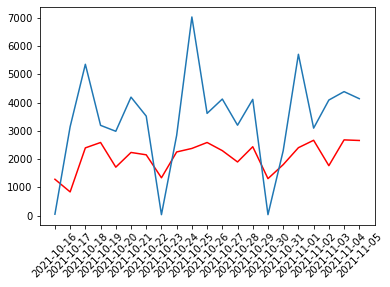

In [10]:
# check model performance
plt.plot(test["date"], pred_y, c = 'red')
plt.plot(test["date"], test_y)
plt.xticks(rotation = 45)
pass

# Hyperparameter tuning by randomized search

In [36]:
from sklearn.model_selection import RandomizedSearchCV

In [37]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [5, 10, 15, 20]
        }

In [38]:
xgb = XGBRegressor(learning_rate = 0.02, 
                    n_estimators = 600, 
                    subsample =  1.0,
                    objective ='reg:squarederror')

In [39]:

#param_comb = 5

#skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

random_search.fit(train_X, train_y)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 82.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 310.9min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.02,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=600, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [40]:
random_search.best_params_

{'min_child_weight': 1, 'max_depth': 20, 'gamma': 1.5, 'colsample_bytree': 0.8}

In [42]:
xgb = XGBRegressor(learning_rate = 0.02, 
                    n_estimators = 600, 
                    subsample =  1.0,
                   min_child_weight = 1, 
                   max_depth = 20, 
                   gamma = 1.5, 
                   colsample_bytree = 0.8,
                    objective ='reg:squarederror')

In [43]:
xgb.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
import joblib
# save model
joblib.dump(xgb, "./whole_xgboost.joblib")

['./whole_xgboost.joblib']

In [45]:
pred_y = xgb.predict(test_X)

In [49]:
print('Root Mean Squared Error (RMSE):', np.sqrt(np.sum((test_y - pred_y)**2)/len(pred_y)))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_y, pred_y))

Root Mean Squared Error (RMSE): 5091.566218551627
Mean Absolute Error (MAE): 2299.3876742307


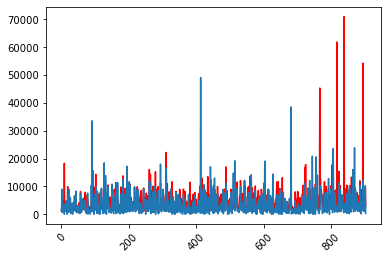

In [53]:
# check model performance
plt.plot(pred_y, c = 'red')
plt.plot(test_y)
plt.xticks(rotation = 45)
pass

## no need

In [140]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

test = test.drop(['cumulative_tested'], axis = 1)
train = train.drop(['cumulative_tested'], axis = 1)

test = test[test.subregion1_code == SAMPLE]
train = train[train.subregion1_code == SAMPLE]

In [141]:
test_X = test.drop(['subregion1_code', 'date', 'cumulative_confirmed'], axis = 1)
test_y = test.new_confirmed
test_X = test_X.drop(['new_confirmed'], axis = 1)

train_X = train.drop(['subregion1_code', 'date', 'cumulative_confirmed'], axis = 1)
train_y = train.new_confirmed
train_X = train_X.drop(['new_confirmed'], axis = 1)

In [142]:
random_search = XGBRegressor(learning_rate = 0.02,
                             n_estimators = 600, 
                             objective = 'reg:squarederror',
                             subsample = 1.0, 
                             min_child_weight = 1, 
                             max_depth = 5, 
                             gamma = 1.5, 
                             colsample_bytree = 0.8)

In [143]:
random_search.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=1.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
pred_y = random_search.predict(test_X)

In [145]:
print('Root Mean Squared Error (RMSE):', np.sqrt(np.sum((test_y - pred_y)**2)/len(pred_y)))

mape = np.mean(np.abs((test_y - pred_y) / np.abs(test_y)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Root Mean Squared Error (RMSE): 1804.316719890119
Mean Absolute Percentage Error (MAPE): 689.88
Accuracy: -589.88


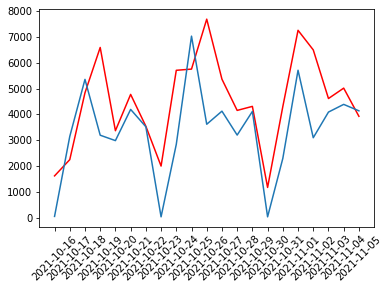

In [146]:
# check model performance
plt.plot(test["date"], pred_y, c = 'red')
plt.plot(test["date"], test_y)
plt.xticks(rotation = 45)
pass

In [7]:
random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 5,
 'max_depth': 7,
 'gamma': 1,
 'colsample_bytree': 1.0}